In [1]:
from pykitti import odometry

In [2]:
sequence_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']

In [3]:
import os
dataset_dir = "/mnt/data/kitti_odometry"
calib_path ="data_odometry_calib"
image_path ="data_odometry_color"
velodyne_path = "data_odometry_velodyne"
imagegray_path = "data_odometry_gray"
poses_path = "data_odometry_poses"
val_RT_path = "data_odometry_valRT"
GTs_R = {}
GTs_T = {}
GTs_T_cam02_velo = {}
K = {}
all_files = []

In [4]:
calib_path_total = os.path.join(dataset_dir,calib_path,"dataset")
image_path_total = os.path.join(dataset_dir,image_path,"dataset")
imagegray_path_total = os.path.join(dataset_dir,imagegray_path,"dataset")
velodyne_path_total = os.path.join(dataset_dir,velodyne_path,"dataset")
poses_path_total = os.path.join(dataset_dir,poses_path,"dataset")
val_RT_path_total = os.path.join(dataset_dir,val_RT_path,"dataset")
suf = ".png"
val_sequence='00'
split ="val"
max_t=1.5
max_r=20

In [5]:
def get_2D_lidar_projection(pcl, cam_intrinsic):
    pcl_xyz = cam_intrinsic @ pcl.T
    pcl_xyz = pcl_xyz.T
    pcl_z = pcl_xyz[:, 2]
    pcl_xyz = pcl_xyz / (pcl_xyz[:, 2, None] + 1e-10)
    pcl_uv = pcl_xyz[:, :2]

    return pcl_uv, pcl_z

def lidar_project_depth(pc_rotated, cam_calib, img_shape):
    #pc_rotated = pc_rotated[:3, :].detach().cpu().numpy()
    pc_rotated = pc_rotated[:3, :]
    #cam_intrinsic = cam_calib.numpy()
    cam_intrinsic = cam_calib
    pcl_uv, pcl_z = get_2D_lidar_projection(pc_rotated.T, cam_intrinsic)
    mask = (pcl_uv[:, 0] > 0) & (pcl_uv[:, 0] < img_shape[1]) & (pcl_uv[:, 1] > 0) & (
            pcl_uv[:, 1] < img_shape[0]) & (pcl_z > 0)
    pcl_uv = pcl_uv[mask]
    pcl_z = pcl_z[mask]
    pcl_uv = pcl_uv.astype(np.uint32)
    pcl_z = pcl_z.reshape(-1, 1)
    depth_img = np.zeros((img_shape[0], img_shape[1], 1))
    depth_img[pcl_uv[:, 1], pcl_uv[:, 0]] = pcl_z
    depth_img = torch.from_numpy(depth_img.astype(np.float32))
    depth_img = depth_img.cuda()
    depth_img = depth_img.permute(2, 0, 1)

    return depth_img, pcl_uv ,pcl_z 

def rotate_points(PC, R, T=None, inverse=True):
    if T is not None:
        R = R.to_matrix()
        R.resize_4x4()
        T = mathutils.Matrix.Translation(T)
        RT = T@R
    else:
        RT=R.copy()
    if inverse:
        RT.invert_safe()
    RT = torch.tensor(RT, device=PC.device, dtype=torch.float)

    if PC.shape[0] == 4:
        PC = torch.mm(RT, PC)
    elif PC.shape[1] == 4:
        PC = torch.mm(RT, PC.t())
        PC = PC.t()
    else:
        raise TypeError("Point cloud must have shape [Nx4] or [4xN] (homogeneous coordinates)")
    return PC

def overlay_imgs(rgb, lidar, idx=0):
    std = [0.229, 0.224, 0.225]
    mean = [0.485, 0.456, 0.406]

    #rgb = rgb.clone().cpu().permute(1,2,0).numpy()
    rgb = rgb.clone().cpu().numpy()
    print(rgb.shape)
    rgb = rgb*std+mean
    #lidar = lidar.clone()
    
    print("lidar=" , lidar.shape)
    lidar = lidar.unsqueeze(0)
    
    lidar[lidar == 0] = 1000.
    lidar = -lidar
    #lidar = F.max_pool2d(lidar, 3, 1, 1)
    lidar = F.max_pool2d(lidar, 3, 1, 1)
    lidar = -lidar
    lidar[lidar == 1000.] = 0.

    #lidar = lidar.squeeze()
    lidar = lidar[0][0]
    lidar = (lidar*255).int().cpu().numpy()
    lidar_color = cm.jet(lidar)
    lidar_color[:, :, 3] = 0.5
    lidar_color[lidar == 0] = [0, 0, 0, 0]
    blended_img = lidar_color[:, :, :3] * (np.expand_dims(lidar_color[:, :, 3], 2)) + \
                  rgb * (1. - np.expand_dims(lidar_color[:, :, 3], 2))
    blended_img = blended_img.clip(min=0., max=1.)
    #io.imshow(blended_img)
    #io.show()
    #plt.figure()
    #plt.imshow(blended_img)
    #io.imsave(f'./IMGS/{idx:06d}.png', blended_img)
    return blended_img , rgb , lidar_color

# From Github https://github.com/balcilar/DenseDepthMap
def dense_map (Pts ,n, m, grid):
    ng = 2 * grid + 1

    mX = np.zeros((m,n)) + np.float("inf")
    mY = np.zeros((m,n)) + np.float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]

    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))

    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])

    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s

    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out   

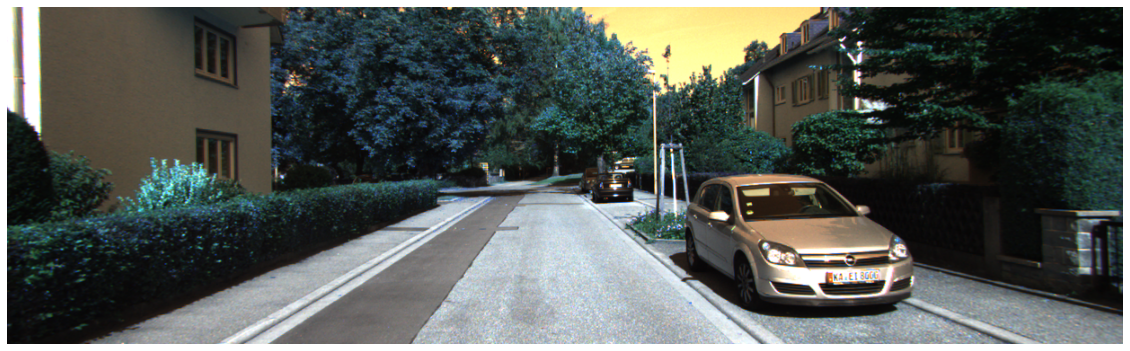

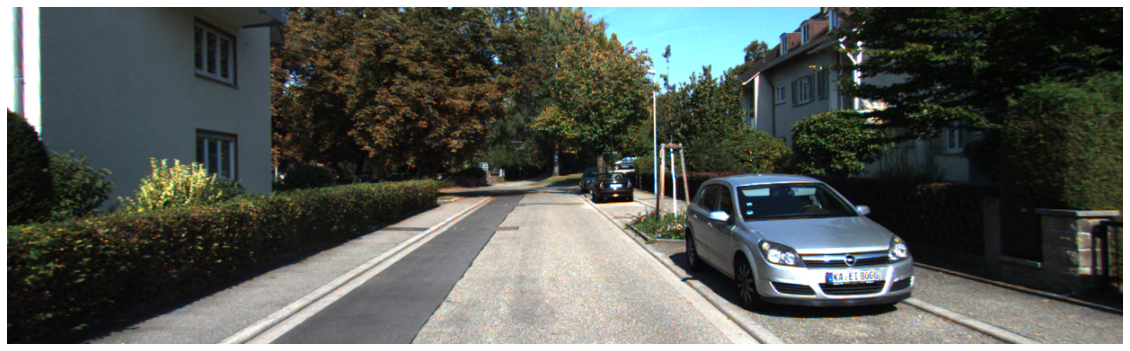

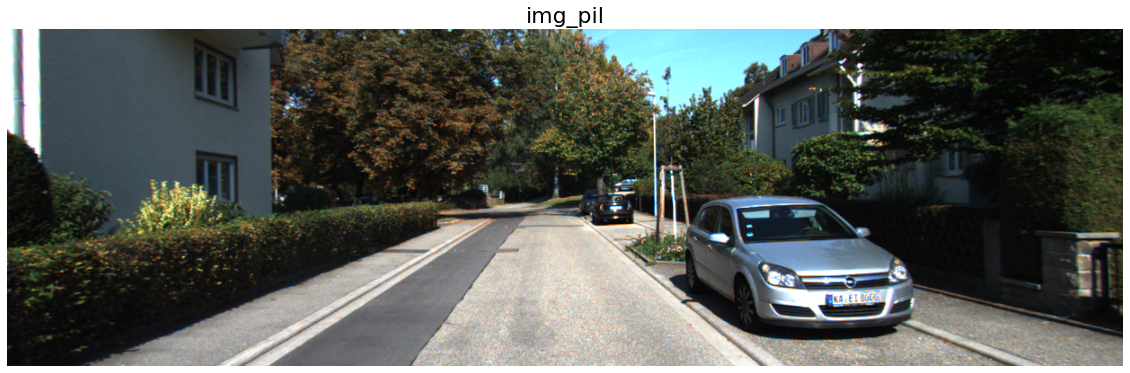

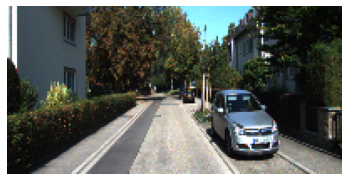

(-0.5, 199.5, 99.5, -0.5)

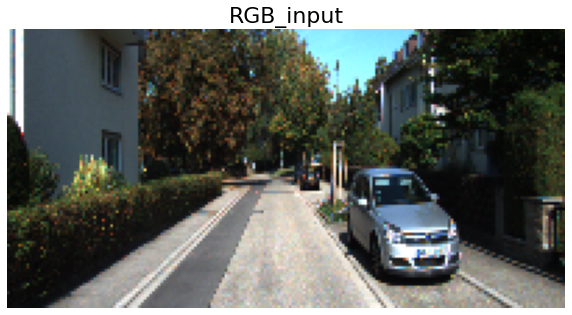

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pykitti import odometry
import torch
import torch.nn.functional as F
from matplotlib import cm
from PIL import Image
import mathutils
from PIL import Image
from torchvision import transforms
import torchvision

# /mnt/data/kitti_odometry/data_odometry_color/dataset/sequences/03/image_2
# /mnt/data/kitti_odometry/data_odometry_velodyne/dataset/sequences/03/velodyne
# /mnt/data/kitti_odometry/data_odometry_calib/dataset/sequences/03
# /mnt/data/kitti_odometry/data_odometry_poses/dataset/poses
calib_path_total = '/mnt/data/kitti_odometry/data_odometry_calib/dataset/'
poses_path_total = '/mnt/data/kitti_odometry/data_odometry_poses/dataset/poses/'  

img_bgr=cv2.imread('/mnt/data/kitti_odometry/data_odometry_color/dataset/sequences/03/image_2/000001.png')# , cv2.IMREAD_COLOR)
img_pil = Image.open('/mnt/data/kitti_odometry/data_odometry_color/dataset/sequences/03/image_2/000001.png').convert('RGB')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_pil_np = np.array(img_pil)
img_pil_resized = cv2.resize(img_pil_np, (200,100), interpolation=cv2.INTER_LINEAR)
img_pil_resized_pytorch = transforms.ToTensor()(img_pil_resized)
# img_shape=np.asarray(img).shape
# print('------img_shape--------' ,np.asarray(img).shape)
# lidar_scan = np.fromfile('/mnt/data/kitti_odometry/data_odometry_velodyne/dataset/sequences/03/velodyne/000001.bin', dtype=np.float32)
# pc = lidar_scan.reshape((-1, 4))
# valid_indices = pc[:, 0] < -3.
# valid_indices = valid_indices | (pc[:, 0] > 3.)
# valid_indices = valid_indices | (pc[:, 1] < -3.)
# valid_indices = valid_indices | (pc[:, 1] > 3.)
# pc = pc[valid_indices].copy()
# print(pc.shape)
# odom = odometry(calib_path_total, poses_path_total, '03')
# calib = odom.calib
# T_cam02_velo_np = calib.T_cam2_velo #gt pose from cam02 to velo_lidar (T_cam02_velo: 4x4)
# K = calib.K_cam2
# #print(T_cam02_velo_np)

# max_angle = 15
# max_t = 1.0
# rotz = np.random.uniform(-max_angle, max_angle) * (3.141592 / 180.0)
# roty = np.random.uniform(-max_angle, max_angle) * (3.141592 / 180.0)
# rotx = np.random.uniform(-max_angle, max_angle) * (3.141592 / 180.0)
# transl_x = np.random.uniform(-max_t, max_t)
# transl_y = np.random.uniform(-max_t, max_t)
# transl_z = np.random.uniform(-max_t, max_t)

# R = mathutils.Euler((rotx, roty, rotz))
# T = mathutils.Vector((transl_x, transl_y, transl_z))

# pc_in = np.matmul(T_cam02_velo_np, pc.T)
# pc_in_torch = torch.from_numpy(pc_in.astype(np.float32)).cuda()
# mis_pc_in = rotate_points(pc_in_torch, R, T)
# mis_pc_in = mis_pc_in.cpu().numpy()
# print('mis_pc_in.shape=', mis_pc_in.shape)
# #print(img_torch.shape)
# #print(img_torch[0].shape)
# depth_gt, uv , z = lidar_project_depth(pc_in, K , img_shape)
# depth_mis, uv_mis , z_mis  = lidar_project_depth(mis_pc_in, K , img_shape)

# lidarOnImage = np.hstack([uv, z])
# dense_depth_img = dense_map(lidarOnImage.T , 1242, 376 , 50)

# # lidarOnImage_mis = np.hstack([uv_mis, z_mis])
# # dense_depth_img_mis = dense_map(lidarOnImage_mis.T , 1242, 376 , 12)

# #cv2.imshow("rgb", img)
# #cv2.waitKey(0)
# #cv2.destroyAllWindows()
# print('depth_mis.shape=', depth_mis.shape)
# img_torch = torch.from_numpy(img).cuda()

# print("depth_gt.shape=", depth_gt.shape)
# out0 , rgb_show , lidar_raw_show = overlay_imgs(img_torch, depth_gt)
# out1 , rgb_show1 , mis_lidar_raw_show = overlay_imgs(img_torch, depth_mis)

# dpi = 1200
# height,width,channel = np.asarray(img_bgr).shape
# figsize = width / float(dpi), height / float(dpi)
# print ('-------figsize-------' , figsize )
# print ('dpi=' , dpi)

plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(img_bgr)
# plt.savefig('rgb.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white' 
#              , dpi=dpi, transparent=True)
plt.show()

plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(img_rgb)
# plt.savefig('rgb.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white' 
#              , dpi=dpi, transparent=True)
plt.show()

plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(img_pil)
plt.title("img_pil", fontsize=22)
# plt.savefig('rgb.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white' 
#              , dpi=dpi, transparent=True)
plt.show()

plt.axis('off')
plt.imshow(img_pil_resized)
# plt.savefig('rgb.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white' 
#              , dpi=dpi, transparent=True)
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(img_pil_resized_pytorch).permute(1,2,0).cpu().numpy())
plt.title("RGB_input", fontsize=22)
plt.axis('off')

# plt.figure(figsize=(20,40))
# plt.axis('off')
# plt.imshow(lidar_raw_show , cmap = 'magma')
# # plt.savefig('sparse_depth.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white'
# #            , dpi=dpi, transparent=True)
# plt.show()

# # plt.figure(figsize=(20,40))
# # plt.axis('off')
# # plt.imshow(mis_lidar_raw_show)
# # # plt.savefig('mis_sparse_depth.png', bbox_inches='tight',pad_inches = 0 , edgecolor = 'white'
# # #            , dpi=dpi, transparent=True)
# # plt.show()

# plt.figure(figsize=(20,40))
# plt.axis('off')
# plt.imshow(dense_depth_img ,cmap ='magma')
# plt.show()

# plt.figure(figsize=(20,40))
# plt.axis('off')
# plt.imshow(dense_depth_img_mis)
# plt.show()
# print ("rgb_show_shape=" ,rgb_show1.shape )
# print ("lidar_raw_show_shape=" ,lidar_raw_show.shape )
# print ("mis_lidar_raw_show_shape=" ,mis_lidar_raw_show.shape )
# #im1 = Image.fromarray(rgb_show1)
# #im1.save("rgb.jpeg")
# #print ('------ rgb file saved ---------')

# #im2 = Image.fromarray(lidar_raw_show)
# #im2.save("sparse_depth.jpeg")

# #scale=1000.0
# #data_np = data.data[0].cpu().float().numpy()
# #data_np = lidar_raw_show 
# #data_np = lidar_raw_show.astype(np.uint16)
# #data_pil = Image.fromarray(lidar_raw_show)
# #data_pil = Image.fromarray(np.squeeze(lidar_raw_show), mode='I;16').convert(mode='I')

# #data_pil.save("sparse_depth.png") 
# print ('------ sparse_depth file saved ---------')

# """
# for seq in sequence_list :
#     image_list = os.listdir(os.path.join(image_path_total, 'sequences', seq, 'image_2'))
#     image_list.sort()
#     for image_name in image_list:
#         file_name = image_path_total +"/" + image_name
#         #print (file_name)
#         print (image_name)
        
#         img=cv2.imread(file_name)
#         print(img)
#         cv2.imshow("rgb", img)
#         cv2.waitKey(0)
#         """

In [7]:
import numpy as np
a =np.random.random((5,3))
a1 = np.random.random((5,3))

In [12]:
a2=[]
a2.append(a)
a2.append(a1)
np.ndarray()

AttributeError: 'list' object has no attribute 'shape'